    Image Dection using SVM and HOG

In [1]:
from model import *

import numpy as np
import cv2
import glob

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.ndimage.measurements import label
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
# Load Images...
eye_images = glob.glob("eye_data/eye_image/*/*.png")
noneye_images = glob.glob("eye_data/noneye_image/*.png")

eye_img, noneye_img = [], []

for img in eye_images:
    eye_img.append(img)
    
for img in noneye_images:
    noneye_img.append(img)
    
print("Length of eye images    : ", len(eye_img))
print("Length of noneye images : ", len(noneye_img))

Length of eye images    :  409
Length of noneye images :  402


In [3]:
# some of Training dataset is CMYK mode so convet to RGB
from PIL import Image

temp = []
eye_image, noneye_image = [], []
for idx in range(len(eye_img)):
    temp = Image.open(eye_img[idx])
    eye_image.append(temp.convert("RGB"))

temp = []
for idx in range(len(noneye_img)):
    temp = Image.open(noneye_img[idx])
    noneye_image.append(temp.convert("RGB"))

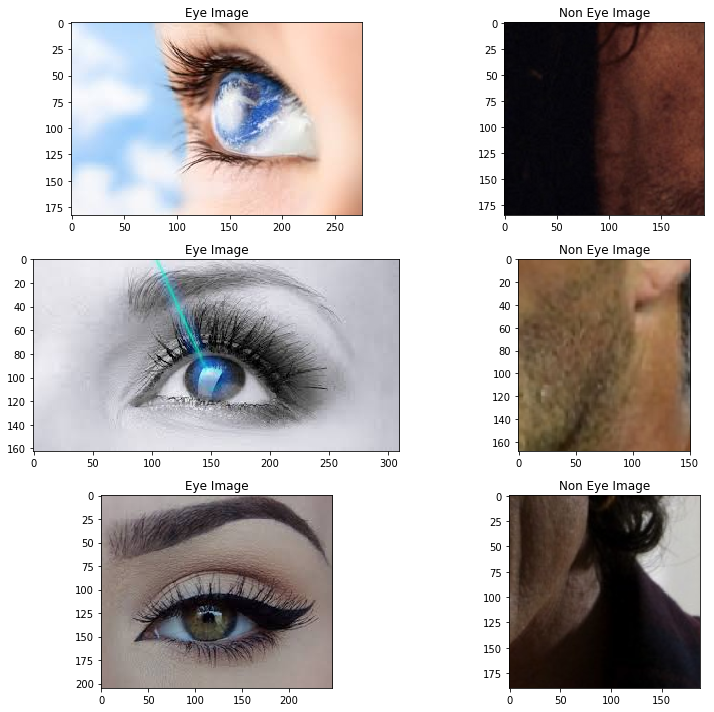

In [4]:
# Plot some images..
fig = plt.figure(figsize=(12, 10))

for i in range(6):
    img = fig.add_subplot(3, 2, i+1)
    
    if i % 2 == 0:
        idx = np.random.randint(1, len(eye_img))
        plt.imshow(eye_image[idx])
        img.set_title("Eye Image")
    else:
        idx = np.random.randint(1, len(noneye_img))
        plt.imshow(noneye_image[idx])
        img.set_title("Non Eye Image")

plt.tight_layout()

In [5]:
# Rescaling 64 * 64
re_eye_img, re_noneye_img = [], []

for img in eye_image:
    re_eye_img.append(cv2.resize(np.asarray(img), (64, 64)))
    
for img in noneye_image:
    re_noneye_img.append(cv2.resize(np.asarray(img), (64, 64)))
    

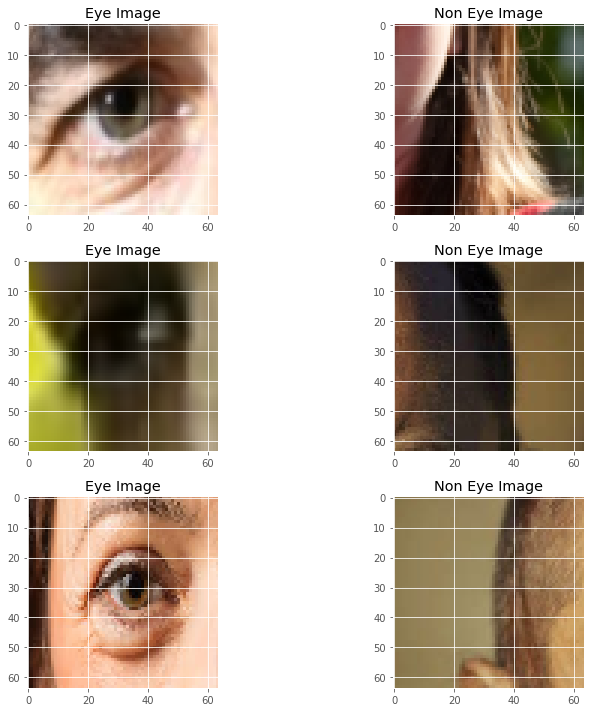

In [6]:
# Plot some images..
fig = plt.figure(figsize=(12, 10))
plt.style.use("ggplot")

for i in range(6):
    img = fig.add_subplot(3, 2, i+1)
    
    if i % 2 == 0:
        idx = np.random.randint(1, len(eye_img))
        plt.imshow(re_eye_img[idx])
        img.set_title("Eye Image")
    else:
        idx = np.random.randint(1, len(noneye_img))
        plt.imshow(re_noneye_img[idx])
        img.set_title("Non Eye Image")

plt.tight_layout()

In [7]:
# Parameters
spatial_size = (16, 16)
hist_bins = 32
hist_range = (0, 256)
orient = 8
pixel_per_cell = 8
cell_per_block = 2
hog_channel = "ALL"

In [8]:
# Get features 
eye_features = extract_features(re_eye_img, spatial_size=spatial_size, hist_bins=hist_bins,
                               hist_range=hist_range, orient=orient,
                                pixel_per_cell=pixel_per_cell, cell_per_block=cell_per_block,
                               hog_channel=hog_channel)
print(len(eye_features[1]))
noneye_features = extract_features(re_noneye_img, spatial_size=spatial_size, hist_bins=hist_bins,
                               hist_range=hist_range, orient=orient,
                                pixel_per_cell=pixel_per_cell, cell_per_block=cell_per_block,
                               hog_channel=hog_channel)


C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


5568


In [9]:
# Create taining and test set

X = np.vstack((eye_features, noneye_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(eye_features)), np.zeros(len(noneye_features))))

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.3,
                                                   random_state=3)

X_train, y_train = shuffle(X_train, y_train, random_state=3)

In [10]:
%%time
# Support Vector Machine
svc = LinearSVC()
svc.fit(X_train, y_train)

print("Test Accuracy of SVC : ", round(svc.score(X_test, y_test), 4))

# LogisticRegression
Logreg = LogisticRegression()
Logreg.fit(X_train, y_train)

print("Test Accuracy of LogisticRegression : ", round(Logreg.score(X_test, y_test), 4))

Test Accuracy of SVC :  0.9385
Test Accuracy of LogisticRegression :  0.9426
Wall time: 1.05 s


In [11]:
# Test sliding window
def Detection_Test(img, clf, scaler, spartial_size=(16, 16), hist_bins=32, orient=8,
                  pixel_per_cell=8, cell_per_block=2, hog_channel="ALL", threshold=10):
    fig = plt.figure(figsize=(15, 35))
    
    eye_image = mpimg.imread(img)
    
    eye_image = cv2.resize(eye_image, (512, 512)) 
    #eye_image = eye_image.astype(np.float32) / 255
    window1 = sliding_window(eye_image,
                          x_start=[int(eye_image.shape[0]/5), int((eye_image.shape[0]*4)/5)],
                          y_start=[int(eye_image.shape[1]/5), int((eye_image.shape[0]*4)/5)],
                          xy_window=(20, 20), xy_overlap=(0.75, 0.75))
    
    window2 = sliding_window(eye_image,
                          x_start=[int(eye_image.shape[0]/5), int((eye_image.shape[0]*4)/5)],
                          y_start=[int(eye_image.shape[1]/5), int((eye_image.shape[0]*4)/5)],
                          xy_window=(25, 25), xy_overlap=(0.75, 0.75))
    
    window3 = sliding_window(eye_image,
                          x_start=[int(eye_image.shape[0]/5), int((eye_image.shape[0]*4)/5)],
                          y_start=[int(eye_image.shape[1]/5), int((eye_image.shape[0]*4)/5)],
                          xy_window=(30, 30), xy_overlap=(0.75, 0.75))
    
    windows =  window1 + window2 + window3
    
    hot_windows = search_windows(eye_image, windows, clf, scaler, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient,
                                pixel_per_cell=pixel_per_cell,
                                cell_per_block=cell_per_block, hog_channel=hog_channel)
    print("Number of candidate windows : ", len(hot_windows))

    heatmap_image = np.zeros_like(eye_image)
    heatmap_image = heatmap(heatmap_image, windows=hot_windows)
    
    plt.subplot(3,1,1)
    plt.title("Heatmap Image")
    plt.imshow(heatmap_image)
    heatmap_image = apply_threshold(heatmap_image, threshold)
    plt.subplot(3,1,2)
    plt.title("Apply Threshold")
    plt.imshow(heatmap_image)

    labels = label(heatmap_image)

    # Bounding box around label
    image = draw_labeled_bboxes(eye_image, labels)
    plt.subplot(3,1,3)
    plt.title("Eye Detection")
    plt.imshow(image)


x pix per step :  5
y pix per step :  5
number of X windows :  60
number of Y windows :  60
Total number of windows :  3600
x pix per step :  6
y pix per step :  6
number of X windows :  50
number of Y windows :  50
Total number of windows :  2500
x pix per step :  7
y pix per step :  7
number of X windows :  42
number of Y windows :  42
Total number of windows :  1764


C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Number of candidate windows :  156
Wall time: 43.6 s


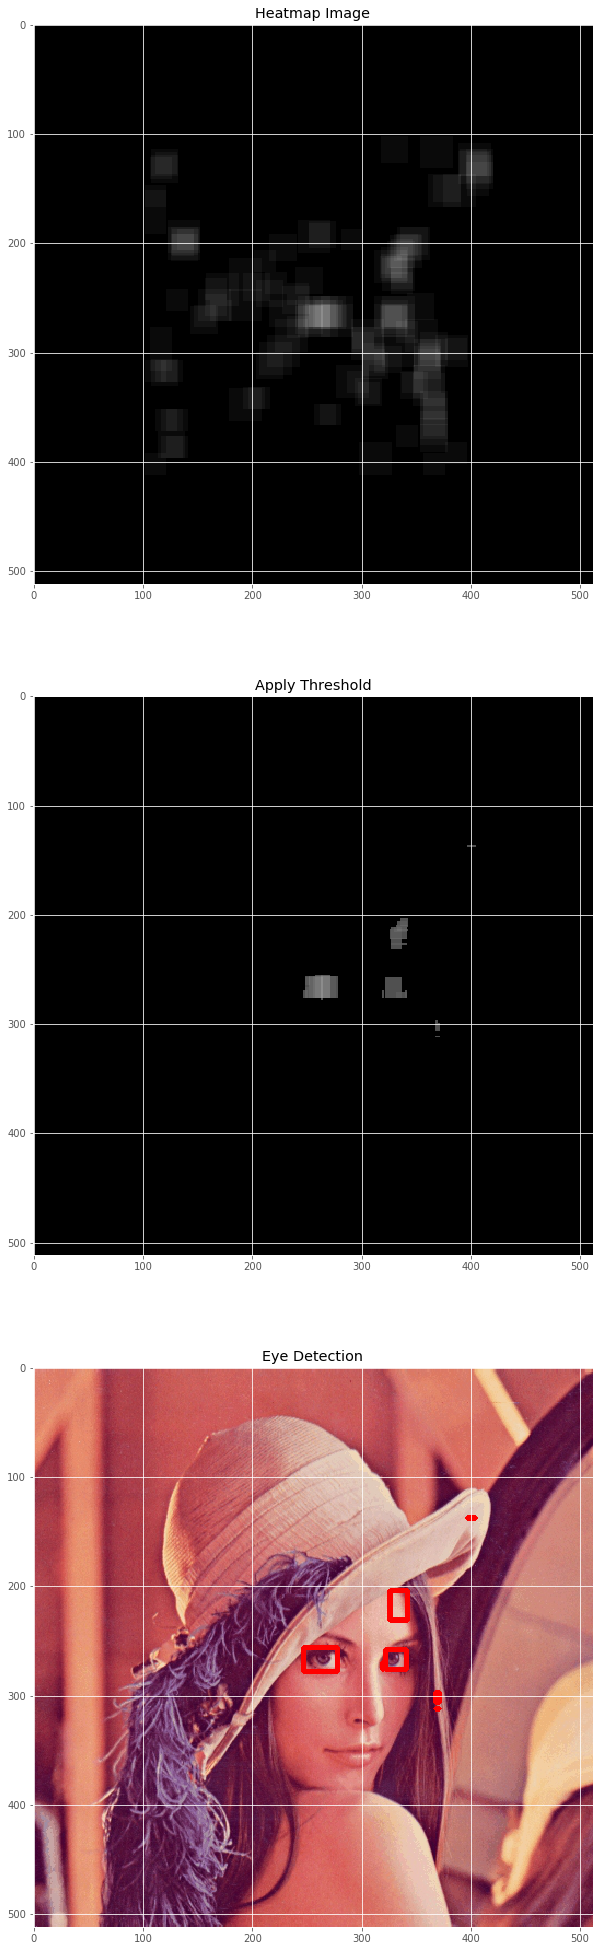

In [25]:
%%time
# Test
test_image = "test/Lena.jpg"
threshold = 70
Detection_Test(test_image, clf=svc, scaler=X_scaler, threshold=threshold)

x pix per step :  5
y pix per step :  5
number of X windows :  60
number of Y windows :  60
Total number of windows :  3600
x pix per step :  6
y pix per step :  6
number of X windows :  50
number of Y windows :  50
Total number of windows :  2500
x pix per step :  7
y pix per step :  7
number of X windows :  42
number of Y windows :  42
Total number of windows :  1764


C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Number of candidate windows :  334


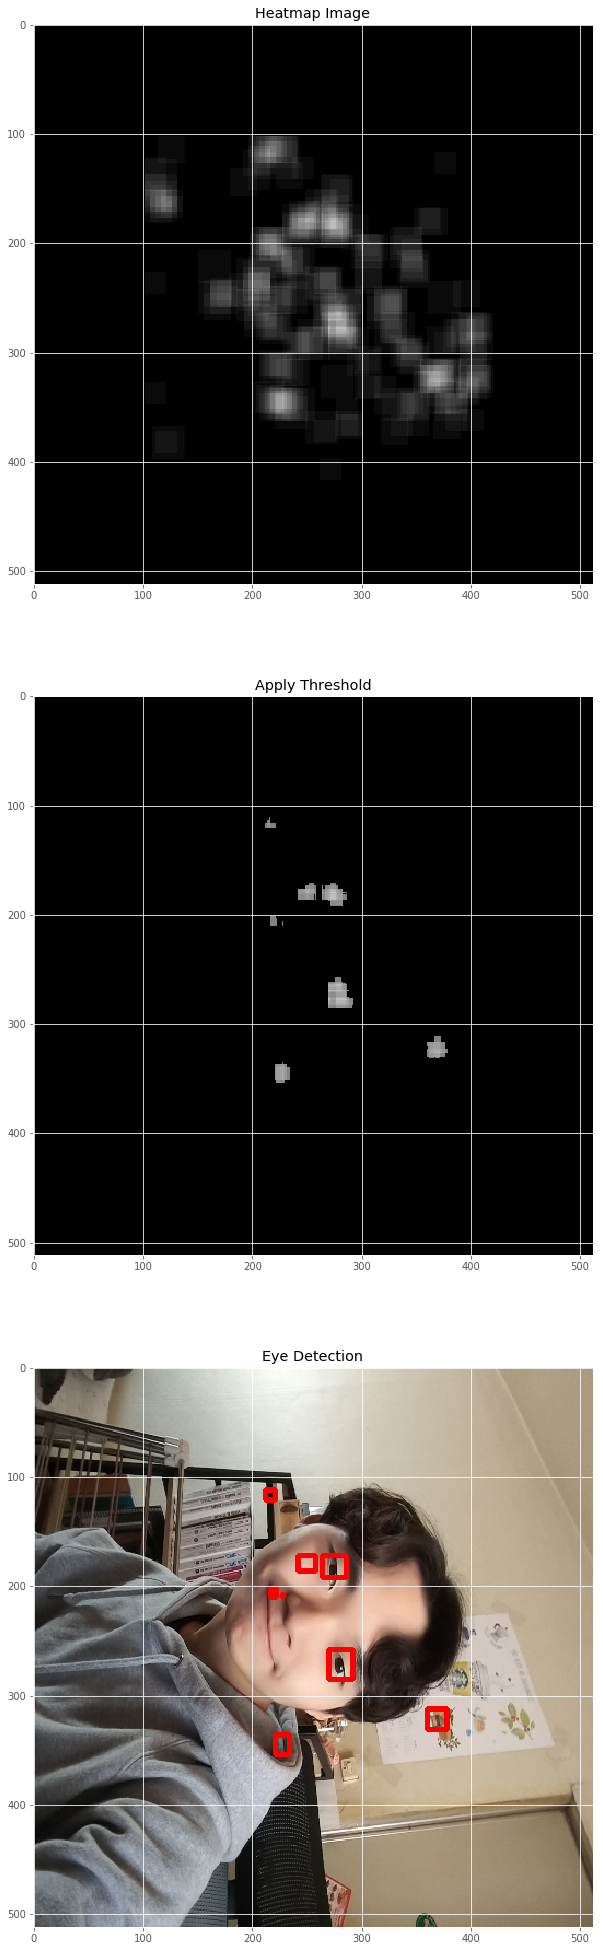

In [23]:
test_image = "test/selfi.jpg"
threshold = 120
Detection_Test(test_image, clf=svc, scaler=X_scaler,  threshold=threshold)

In [14]:
#Simple Neural Net
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import Flatten
#from keras.layers.convolutional import Conv2D
#from keras.layers.convolutional import MaxPooling2D

In [15]:
#model = Sequential()

#model = Sequential()
#model.add(Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=(64, 64, 3)))
#model.add(Flatten())
#model.add(Dense(1, activation="sigmoid"))

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#print(model.summary())

In [16]:
#re_eye_img = np.asarray(re_eye_img)

#re_noneye_img = np.asarray(re_noneye_img)

#X = np.concatenate((re_eye_img, re_noneye_img))
#y = np.hstack((np.ones(re_eye_img.shape[0]), np.zeros(re_noneye_img.shape[0])))

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [17]:
#model.fit(X_train, y_train, epochs = 20, batch_size=32)

In [18]:
#model.evaluate(x=X_test, y=y_test)